# TP : Decision trees and ensemble methods

In the first part, you are asked to implement a **Stump**, i.e. a decision tree of depth 1, from scratch. Our tree should be able to handle weighted and unweighted samples, in order for it to be used as a weak learner for
**AdaBoost** in the second part.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from sklearn.datasets import make_moons, make_circles, make_classification

The following code creates 3 synthetic datasets, in which there are just two features, for binary classification. We ask you to provide the solutions to the exercises on all elements of the list ```datasets```.

/var/folders/1j/t6gknhqx72j4f3j_4q1sdzmr0000gn/T/ipykernel_50250/2886069118.py:21: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax[fi].scatter(X[idx, 0], X[idx, 1], c=color,  cmap=plt.cm.RdYlBu, edgecolor='black', s=100)


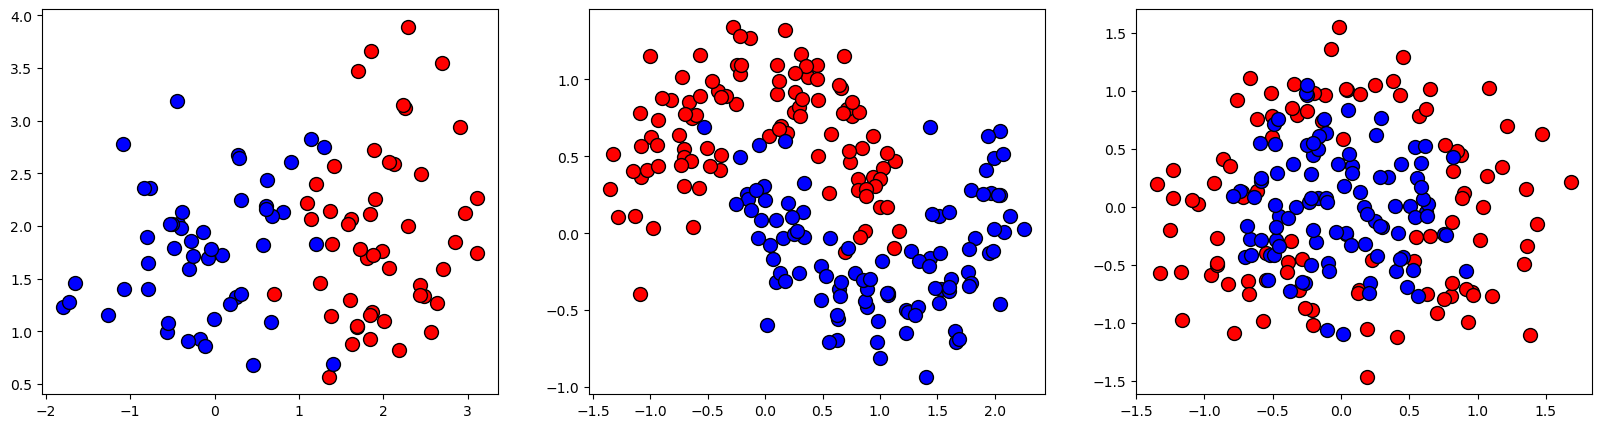

In [2]:
plot_colors = "rb"
X, y = make_classification(n_features=2, n_redundant=0, n_informative=2,
                           random_state=1, n_clusters_per_class=1)
rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
linearly_separable = (X, y)

datasets = [linearly_separable,
            make_moons(n_samples = 200, noise=0.2, random_state=0),
            make_circles(n_samples = 200, noise=0.3, factor=0.5, random_state=1)
            ]

fig, ax = plt.subplots(1, 3, figsize=(20,5))
for fi in range(len(datasets)):
    dataset = datasets[fi]
    X = dataset[0]
    y = dataset[1]
    n_classes = len(np.unique(y))
    for i, color in zip(range(n_classes), plot_colors):
        idx = np.where(y == i)
        ax[fi].scatter(X[idx, 0], X[idx, 1], c=color,  cmap=plt.cm.RdYlBu, edgecolor='black', s=100)
dataset = datasets[1]

In [3]:
def plot_tree(clf, X, y):
    n_classes = 2
    plot_colors = "rb"
    plot_step = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)
    plt.axis("tight")
    # Plot the training points
    for i, color in zip([-1,1], plot_colors):
        idx = np.where(y == i)
        plt.scatter(X[idx, 0], X[idx, 1], c=color,  cmap=plt.cm.Paired)
    plt.show()

## First part: Stumps

In this first part, you will code your own class to handle stumps for 2-dimensional data and binary classification (i.e., the class takes value in $\{0, 1\}$). You can find the outline of the code you will need to write, following these instructions:
- Implement the ```fit``` method : since the weak learners are potentially executed a large number of times, efficiency is crucial. Use the incremental evaluation of the partitions seen in class : the complexity should be  $O(ndc)$ instead of the naive $O(n^2 dc)$ version. We assume that the sorting operations such as ```argsort``` are free because we only need to run them once. Iterate in the 2-dimensions for every possible split, evaluate the quality of each split using an incremental version of the Gini index (defined next) and store the best split. (Note : a non-incremental version will be graded with half the points)
- Implement the ```gini``` method : Implement the Gini index coefficient for the case in which there are only 2 classes. In class, you saw the unweighted case: we quickly recall the unweighted then weighted version. Let $C$ be the number of different classes, $p_k(S)$ be the ratio of datapoints of class $k$ in region $S$. Then, the Gini index $G(S)$ is $$ G(S) = 1 - \sum_{k=1}^{C} p_k(S)^2$$ Given a split in which we have left and right regions $S_r$, $S_l$, let $N_r$ (resp. $N_l$) be the number of datapoints in $S_r$ (resp. $S_l$). The Gini index of the split is the combination of the Gini index of both regions: $$ \frac{N_r}{N_r + N_l}G(S_r) + \frac{N_l}{N_r + N_l}G(S_l) $$ For generalizing to the weighted case, let $w_k(S)$ be the sum of the weights of all data-points of class $k$ in $S$. The Gini index is defined as follows: $$ G(S) = 1 - \sum_{k=1}^{C} \left( \frac{w_k(S)}{  \sum_{m=1}^{C} w_m(S)} \right)^2 $$ Given a split in which we have left and right regions $S_r$, $S_l$, let $W_r = \sum_{k=1}^{C} w_k(S)$ (resp. $W_l$) the total weight on $S_r$ (resp. $S_l$). The Gini index of the partition is the combination of the Gini index of both regions: $$ \frac{W_r}{W_r + W_l}G(S_r) + \frac{W_l}{W_r + W_l}G(S_l) $$
- Implement the ```predict``` method. The input is an array of $n$ $d$-dimensional observations. The output is a ```np.array``` of length $n$. Once the ```predict``` method is coded, use the given function ```plot_tree(my_stump, X, y)``` to plot ```my_stump``` on each of the ```datasets```.

<div class='alert alert-block alert-info'>
            Code:</div>

            

/var/folders/1j/t6gknhqx72j4f3j_4q1sdzmr0000gn/T/ipykernel_50250/2259686537.py:17: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[idx, 0], X[idx, 1], c=color,  cmap=plt.cm.Paired)


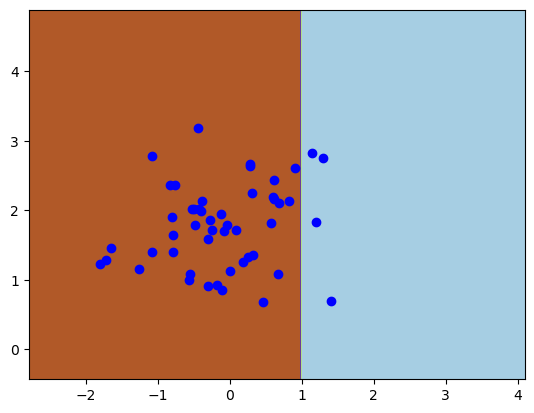

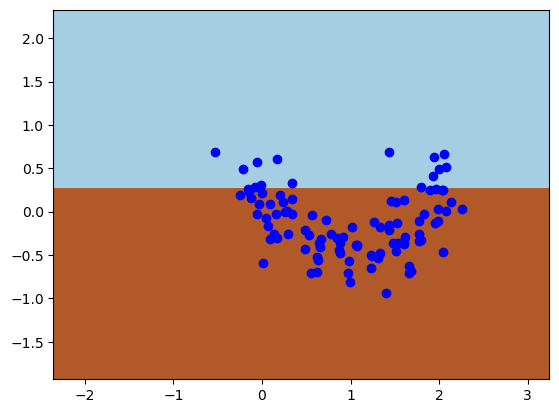

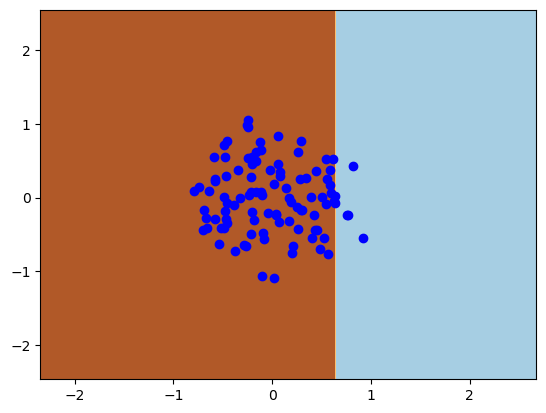

In [11]:
class DecisionStump:
    def __init__(self):
        self.j = None  
        self.t = None  
        self.p = None  

    def fit(self, X, y, sample_weight=None):
        if sample_weight is None:
            sample_weight = np.ones(len(y)) / len(y)
        
        m, n = X.shape
        best_gini = np.inf
        best_j, best_t = None, None
        
        for j in range(n):
            sorted_indices = np.argsort(X[:, j])
            X_sorted = X[sorted_indices, j]
            y_sorted = y[sorted_indices]
            weight_sorted = sample_weight[sorted_indices]
            
            weight_sum = np.cumsum(weight_sorted)
            weight_sum_left = weight_sum - weight_sorted
            weight_sum_right = weight_sum[-1] - weight_sum_left
            
            gini_left = np.zeros(m)
            gini_right = np.zeros(m)
            
            for i in range(1, m):
                left_mask = y_sorted[:i] == 1
                right_mask = y_sorted[i:] == 1
                p_left = np.sum(weight_sorted[:i] * left_mask) / weight_sum_left[i-1] if weight_sum_left[i-1] > 0 else 0
                p_right = np.sum(weight_sorted[i:] * right_mask) / weight_sum_right[i-1] if weight_sum_right[i-1] > 0 else 0
                gini_left[i] = 1 - (p_left ** 2 + (1 - p_left) ** 2)
                gini_right[i] = 1 - (p_right ** 2 + (1 - p_right) ** 2)
            
            gini_split = (weight_sum_left / weight_sum[-1]) * gini_left + (weight_sum_right / weight_sum[-1]) * gini_right

            min_gini_split = np.min(gini_split[1:]) 
            if min_gini_split < best_gini:
                best_gini = min_gini_split
                best_j = j
                best_t = (X_sorted[np.argmin(gini_split[1:]) + 1] + X_sorted[np.argmin(gini_split[1:])]) / 2

        self.j = best_j
        self.t = best_t

        left_mask = X[:, self.j] <= self.t
        right_mask = X[:, self.j] > self.t
        self.p = [np.argmax(np.bincount(y[left_mask], weights=sample_weight[left_mask])),
                  np.argmax(np.bincount(y[right_mask], weights=sample_weight[right_mask]))]

    def gini(self, y, weight):
        total_weight = weight.sum()
        if total_weight == 0:
            return 0
        sum_sq = sum((weight[y == c].sum() / total_weight) ** 2 for c in np.unique(y))
        return 1 - sum_sq

    def predict(self, X):
        return np.where(X[:, self.j] <= self.t, self.p[0], self.p[1])
    
for X, y in datasets:
    stump = DecisionStump()
    stump.fit(X, y)
    plot_tree(stump, X, y)

In [14]:
from sklearn import tree

class My_stump:
    def __init__(self):
        self.best_dimension = None
        self.best_threshold = None
        self.class_below_threshold = None
        self.class_above_threshold = None
        self.best_ev = None
        
    def get_threshold(self): return self.best_threshold
  
    def get_best(self): return self.best_dimension,  self.best_threshold, self.best_ev
    
    def gini_impurity(self, y, sample_weight):
        total_weight = np.sum(sample_weight)
        if total_weight == 0:
            return 0
        sum_sq = sum((np.sum(sample_weight[y == c]) / total_weight) ** 2 for c in np.unique(y))
        return 1 - sum_sq
        
    
    def fit(self, X, y, sample_weight=None):
        if sample_weight is None:
            sample_weight = np.ones(len(y)) / len(y)

        m, n = X.shape
        best_gini = np.inf
        best_j, best_t = None, None
        
        for j in range(n):
            sorted_indices = np.argsort(X[:, j])
            X_sorted = X[sorted_indices, j]
            y_sorted = y[sorted_indices]
            weight_sorted = sample_weight[sorted_indices]

            for i in range(1, m):
                if X_sorted[i] == X_sorted[i - 1]:
                    continue

                threshold = (X_sorted[i] + X_sorted[i - 1]) / 2
                left_mask = X_sorted <= threshold
                right_mask = X_sorted > threshold

                gini_left = self.gini_impurity(y_sorted[left_mask], weight_sorted[left_mask])
                gini_right = self.gini_impurity(y_sorted[right_mask], weight_sorted[right_mask])
                gini_split = (np.sum(weight_sorted[left_mask]) * gini_left +
                              np.sum(weight_sorted[right_mask]) * gini_right) / np.sum(weight_sorted)

                if gini_split < best_gini:
                    best_gini = gini_split
                    best_j = j
                    best_t = threshold

        self.best_dimension = best_j
        self.best_threshold = best_t

        left_mask = X[:, self.best_dimension] <= self.best_threshold
        right_mask = X[:, self.best_dimension] > self.best_threshold
        self.class_below_threshold = np.sign(np.sum(y[left_mask] * sample_weight[left_mask]))
        self.class_above_threshold = np.sign(np.sum(y[right_mask] * sample_weight[right_mask]))
        self.best_ev = best_gini
    
    def predict(self, X) :
        res = []
        return np.array(res)  

- Using ```DecisionTreeClassifier``` in ```sklearn```, fit a stump on the data.

In [15]:
dataset = datasets[1]
X = dataset[0]
y = dataset[1]*2-1 
w = np.ones(len(X)) 

my_stump = My_stump()
my_stump.fit(X, y, w)
my_stump.predict(X)

array([], dtype=float64)

- Check the correctness of your code: With ```tree.plot_tree(sk_stump)``` compare the dimension of the split, the threshold and the Gini indices obtained through your own code and those of ```sk_stump```.

In [16]:
# Check your code
sk_stump = tree.DecisionTreeClassifier(max_depth=1).fit(X, y, sample_weight=w)
my_stump = My_stump()
my_stump.fit(X, y, w)

print("Difference in the best threshold:", sk_stump.tree_.threshold[0] -  my_stump.get_threshold())

plot_tree(my_stump,X,y)
plot_tree(sk_stump,X,y)

Difference in the best threshold: -2.9161397741006567e-09


ValueError: cannot reshape array of size 0 into shape (214,281)

## Second part: Adaboost

Implement the **AdaBoost** seen in class. You can use the ```my_stump``` implemented before. We encourage you to check the correctness by comparing it to ```sk_stump```.
- Implement the ```fit``` function in the provided template using the utility functions.

<div class='alert alert-block alert-info'>
            Code:</div>

In [17]:
class AdaBoost:
    def __init__(self, n_estimators=50):
        self.n_estimators = n_estimators
        self.estimators = []
        self.estimator_weights = []

    def fit(self, X, y):
        n_samples, n_features = X.shape
        sample_weight = np.ones(n_samples) / n_samples

        for t in range(self.n_estimators):
            stump = My_stump()
            stump.fit(X, y, sample_weight)
            y_pred = stump.predict(X)

            incorrect = (y_pred != y)
            estimator_error = np.mean(np.average(incorrect, weights=sample_weight, axis=0))

            if estimator_error >= 0.5:
                break

            alpha = 0.5 * np.log((1 - estimator_error) / estimator_error)
            self.estimators.append(stump)
            self.estimator_weights.append(alpha)

            sample_weight *= np.exp(-alpha * y * y_pred)
            sample_weight /= np.sum(sample_weight)

    def predict(self, X):
        classifier_preds = np.array([stump.predict(X) for stump in self.estimators])
        return np.sign(np.dot(self.estimator_weights, classifier_preds))


In [18]:
import pandas as pd

# Compute the error rate of a weak classifier with weights w_m
def compute_error(y, y_pred, w_m):
    return # TODO - your code here

# Compute alpha 
def compute_alpha(error):
    return # TODO - your code here

# Compute the update of the weights
def update_weights(w_i, alpha, y, y_pred, error):
    return # TODO - your code here


class AdaBoost:
    def __init__(self):
        self.alphas = []
        self.G_M = []
        self.M = None
        self.loss_ensemble = []
        
    def predict(self, X):
        weak_preds = pd.DataFrame(index = range(len(X)), columns = range(self.M)) 
        for m in range(len(self.G_M)):
            y_pred_m = self.G_M[m].predict(X) * self.alphas[m]
            weak_preds.iloc[:,m] = y_pred_m
        y_pred = (1 * np.sign(weak_preds.T.sum())).astype(int)
        return y_pred.values

    def fit(self, X, y, M = 10):
        self.alphas = [] 
        self.training_errors = []
        self.M = M
        Z=1
        for m in range(0, M):# Iterate over M weak classifiers
            if m == 0:
                w_m = np.ones(len(y)) * 1 / len(y)  
            else:
                w_m = update_weights(w_m, alpha_m, y, y_pred, error_m)
                w_m /= np.sum(w_m)  # Normalize weights

            G_m = My_stump()  # Create a new instance of My_stump
            G_m.fit(X, y, w_m)
            y_pred = G_m.predict(X)

            error_m = compute_error(y, y_pred, w_m)
            alpha_m = compute_alpha(error_m)

            self.G_M.append(G_m) # Save to list of weak classifiers
            self.alphas.append(alpha_m)
            Z = Z * (2 * np.sqrt(error_m * (1 - error_m)))
            self.loss_ensemble.append(Z) 
        

- Run the code for 20 iterations. At each iteration, plot the result of the ensemble of AdaBoost ```ab``` using ```plot_tree(ab, X, y)```
- Plot the evolution of the loss in the 20 iterations.

In [19]:
from sklearn.tree import DecisionTreeClassifier

ab = AdaBoost()
ab.fit(X, y, M = 20)
plt.plot(ab.loss_ensemble)
plt.show()
plot_tree(ab, X, y)

TypeError: unsupported operand type(s) for -: 'int' and 'NoneType'